In [1]:
%matplotlib inline
%run ../../path_import.py
from plots import *
from training_reparam import *
from eubo import *
from model_reparam import *

import probtorch
print('probtorch:', probtorch.__version__, 
      'torch:', torch.__version__, 
      'cuda:', torch.cuda.is_available())

probtorch: 0.0+5a2c637 torch: 1.1.0 cuda: True


In [2]:
data_path = "../gmm_dataset_c2k"
Data = torch.from_numpy(np.load(data_path + '/obs.npy')).float()
_, N, D = Data.shape
K = 3 ## number of clusters
## Model Parameters
MCMC_SIZE = 20
SAMPLE_SIZE = 10
NUM_HIDDEN_LOCAL = 32
## Training Parameters
BATCH_SIZE = 20
NUM_EPOCHS = 1000
LEARNING_RATE =  1e-4
CUDA = torch.cuda.is_available()
PATH = 'ag-symKL-resample-%dsteps-%dsamples' % (MCMC_SIZE, SAMPLE_SIZE)

DEVICE = torch.device('cuda:1')

In [3]:
# initialization
enc_z = Gibbs_z(K, CUDA, DEVICE)
enc_eta = Enc_eta(K, D, CUDA, DEVICE)
if CUDA:
    enc_eta.cuda().to(DEVICE)
optimizer =  torch.optim.Adam(list(enc_eta.parameters()),lr=LEARNING_RATE, betas=(0.9, 0.99))

In [4]:
train_cfz_reparam(Eubo_cfz, enc_eta, enc_z, optimizer, Data, K, NUM_EPOCHS, MCMC_SIZE, SAMPLE_SIZE, BATCH_SIZE, PATH, CUDA, DEVICE, RESAMPLE=True)

epoch=0, symKL=13717.413, EUBO=-1494.942, ELBO=-15618.658, ESS=1.363 (36s)
epoch=1, symKL=13178.882, EUBO=-1456.442, ELBO=-15045.782, ESS=1.370 (34s)
epoch=2, symKL=12671.675, EUBO=-1349.889, ELBO=-14430.719, ESS=1.375 (31s)
epoch=3, symKL=12145.179, EUBO=-1314.933, ELBO=-13866.852, ESS=1.381 (33s)
epoch=4, symKL=11680.886, EUBO=-1253.111, ELBO=-13341.288, ESS=1.385 (36s)
epoch=5, symKL=11223.234, EUBO=-1193.091, ELBO=-12824.629, ESS=1.390 (36s)
epoch=6, symKL=10762.463, EUBO=-1135.321, ELBO=-12305.995, ESS=1.392 (36s)
epoch=7, symKL=10330.141, EUBO=-1093.248, ELBO=-11827.899, ESS=1.398 (36s)
epoch=8, symKL=9940.160, EUBO=-1007.057, ELBO=-11353.212, ESS=1.404 (36s)
epoch=9, symKL=9571.783, EUBO=-983.113, ELBO=-10961.834, ESS=1.409 (36s)
epoch=10, symKL=9226.736, EUBO=-919.781, ELBO=-10553.012, ESS=1.409 (35s)
epoch=11, symKL=8891.671, EUBO=-864.580, ELBO=-10165.256, ESS=1.415 (36s)
epoch=12, symKL=8576.169, EUBO=-820.025, ELBO=-9807.992, ESS=1.416 (36s)
epoch=13, symKL=8318.931, EUBO=-

In [5]:
torch.save(enc_eta.state_dict(), '../weights/enc-eta-%s' + PATH)
# torch.save(enc_z.state_dict(), '../weights/enc-z-%s' + PATH)

In [6]:

def test(Eubo, enc_eta, enc_z, Data, K, mcmc_size, sample_size, batch_size, CUDA, device):
    NUM_SEQS, N, D = Data.shape
    indices = torch.randperm(NUM_SEQS)
    batch_indices = indices[0*batch_size : (0+1)*batch_size]
    obs = Data[batch_indices]
    obs = shuffler(obs).repeat(sample_size, 1, 1, 1)
    if CUDA:
        obs =obs.cuda().to(device)
    _, _, _, _, q_eta, p_eta, q_z, p_z, _, _ = Eubo(enc_eta, enc_z, obs, N, K, D, mcmc_size, sample_size, batch_size, device)
    return obs, q_eta, q_z


In [7]:
BATCH_SIZE_TEST = 50
obs, q_eta, q_z = test(Eubo_cfz, enc_eta, enc_z, Data, K, MCMC_SIZE, SAMPLE_SIZE, BATCH_SIZE_TEST, CUDA, DEVICE)

CPU times: user 1.88 s, sys: 33.1 ms, total: 1.91 s
Wall time: 1.87 s


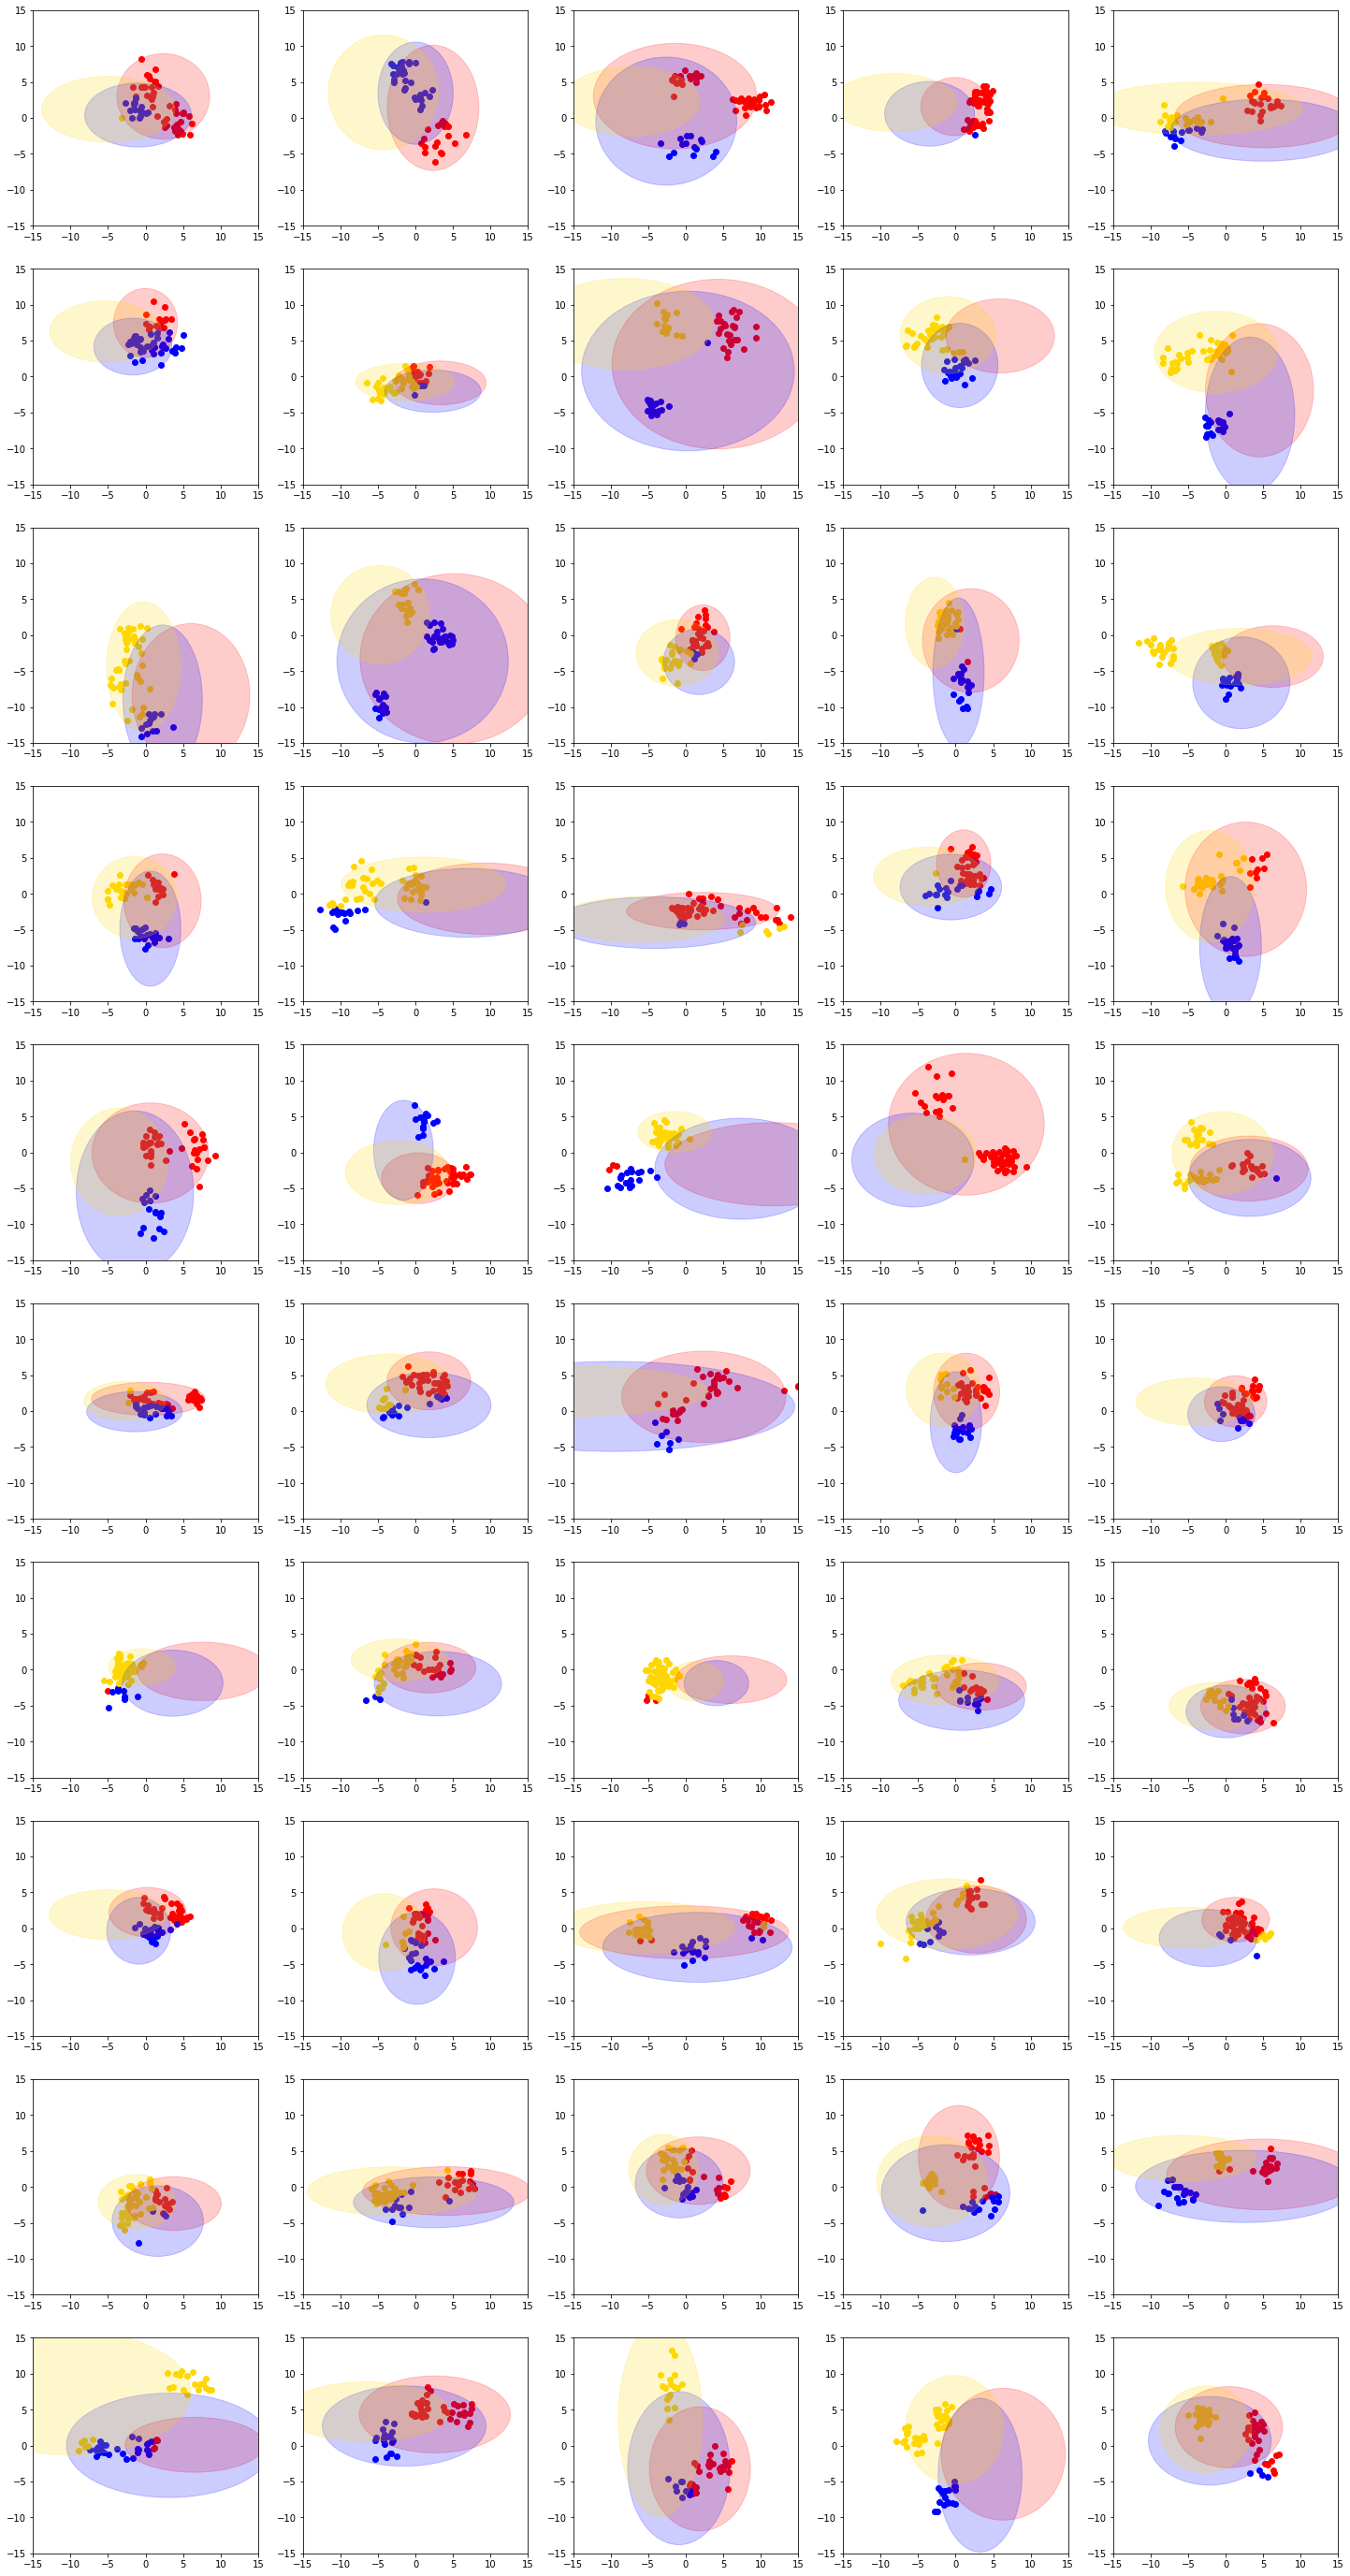

In [8]:
%time plot_samples(obs, q_eta, q_z, PATH)